In [6]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell above will fail. 

# Step 1: Download images of diseased plants and healthy plants

Below, we make sure that we have the latest version of fastai and install fastbook so that we can search for images using dukduckgo. NB: I had issues directly importing and using modules from duckduckgo, using fastbook fixed this problem for me.

In [7]:
!pip install -Uqq fastai
!pip install -q fastbook

Search for diseased plants and see what kind of results we get. First, we get the URLs from a search:

In [8]:
from fastbook import *
from fastcore.all import *

def search_images(term, max = 30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images = max)
    #return L(ddg_images(term, max_result=max_images)).itemgot("image)")
          
urls = search_images("diseased plants")
urls[0]

Searching for 'diseased plants'


'https://earthsally.com/wp-content/uploads/2021/03/blackspot-plant-disease-1024x512.jpg'

Then, we download a URL and take a look at it:

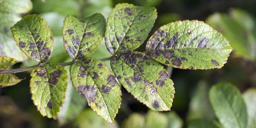

In [9]:
from fastdownload import download_url
dest = "diseased_plant.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
image = Image.open(dest)
image.to_thumb(256, 256)

Next, we do the same with photos of healthy plants.

Searching for 'healthy plants'


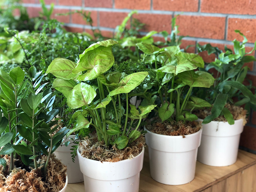

In [10]:
download_url(search_images("healthy plants", max=1)[0], 'healthy_plant.jpg', show_progress=False)
Image.open('healthy_plant.jpg').to_thumb(256, 256)

Since our searches seem to give reasonable results, we grab a few examples of photos of diseased and healthy plants, and save each group to a different folder. We also try to grab photos under different lighting conditions.

In [11]:
searches = "diseased plant", "healthy plant"
path = Path("diseased_or_not")
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o) 

Searching for 'diseased plant photo'
Searching for 'diseased plant sun photo'
Searching for 'diseased plant shade photo'
Searching for 'healthy plant photo'
Searching for 'healthy plant sun photo'
Searching for 'healthy plant shade photo'


# Step 2: Train our model
We start by removing photos that did not download correctly since they could cause our model training to fail:

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

With the fastai library we can create DataLoaders using a DataBlock and also view sample images from it. We need DataLoaders to train a model, which is an object that contains a training set (the images used to create the model) and a validation set (the images used to check the accuracy of a model and not used during training):

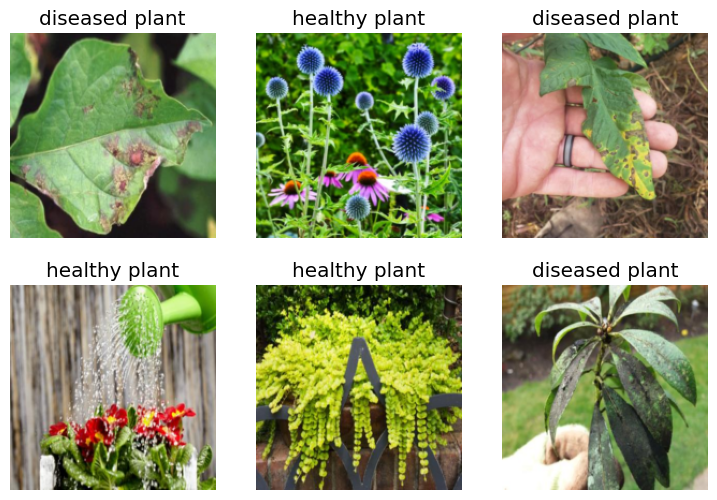

In [13]:
dls = DataBlock(
    # The inputs to our model are images and the outputs are categories
    blocks=(ImageBlock, CategoryBlock), 
    # get_image_files returns a list of all image files in a path
    get_items=get_image_files, 
    # Split the data into training and validation sets randomly
    # using 20% of the data for the validation set
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # The y values is the name of the parent of each file, i.e. the name of
    # the folder they are in which is "diseased plant" and "healthy plant"
    get_y=parent_label,
    # Resize each image to 192x192 pixels before training by squishing
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Next, we train our model. The fastest widely used computer vision model is resnet18, which we can train in a few minutes on a CPU (and generally under 10 second on a GPU). The fine_tune() method of fastai automatically uses best practices for fine tuning a pre-trained model. Fine-tuning a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognize your particular dataset. (In this case, the pretrained model was trained to recognize photos in imagenet.)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 307MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.103496,2.012603,0.484848,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.440083,0.486129,0.212121,00:16
1,0.359871,0.178226,0.090909,00:16
2,0.244016,0.064178,0.000000,00:16
3,0.185658,0.038550,0.000000,00:16


# Step 3: Using our model
Recall that we downloaded an image of a diseased plant at the start of the notebook. We can now see what our model thinks about that plant:

In [15]:
has_disease, _, probability = learn.predict(PILImage.create("diseased_plant.jpg"))
print(f"This is diseased plant: {has_disease}.")
print(f"Probability it's a diseased plant: {probability[0]:.4f}")

This is diseased plant: diseased plant.
Probability it's a diseased plant: 0.9999
